<a href="https://colab.research.google.com/github/Alfikriangelo/DeepLearningTasks/blob/main/UTS/UTSDataset_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from google.colab import drive
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.impute import SimpleImputer

In [2]:
# === 1. Load data ===
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/dataset/RegresiUTSTelkom.csv')

# Cek dan imputasi jika ada nilai yang hilang
imputer = SimpleImputer(strategy='mean')  # Menggunakan rata-rata untuk imputasi
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# beri nama untuk setiap fitur
df_imputed.columns = ['target'] + [f'x{i}' for i in range(1, df_imputed.shape[1])]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# === 2. Buang outlier menggunakan IQR ===
Q1 = df_imputed.quantile(0.25)
Q3 = df_imputed.quantile(0.75)
IQR = Q3 - Q1
iqr_multiplier = 2.0  # bisa diatur untuk lebih ketat/longgar

df_imputed = df_imputed[~((df_imputed < (Q1 - iqr_multiplier * IQR)) | (df_imputed > (Q3 + iqr_multiplier * IQR))).any(axis=1)]

# Debug: jumlah data setelah buang outlier
print(f"\nJumlah data setelah buang outlier: {df_imputed.shape[0]} baris")


Jumlah data setelah buang outlier: 267839 baris


In [4]:
# === 3. Pisahkan fitur dan target ===
y = df_imputed.iloc[:, 0]
X = df_imputed.iloc[:, 1:]

In [5]:
# === 4. Transformasi log1p untuk target ===
y_log = np.log1p(y)  # untuk mengurangi dampak outlier target

In [6]:
# === 5. Split data ===
if len(df_imputed) == 0:
    raise ValueError("Dataset kosong setelah membersihkan outlier. Coba gunakan multiplier IQR yang lebih longgar.")

X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

In [7]:
# === 6. Standardisasi fitur ===
feature_scaler = StandardScaler()
X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

In [8]:
# === 7. Standardisasi target log ===
target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train_log.values.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test_log.values.reshape(-1, 1))

In [9]:
# === 8. Optimized MLP Model ===
model = models.Sequential([
    layers.Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.1),

    layers.Dense(1)
])
model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
# === 9. Callback ===
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [11]:
# === 10. Training ===
model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_test_scaled, y_test_scaled),
    epochs=200,
    batch_size=128,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/200
1674/1674 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step - loss: 0.9489 - val_loss: 0.6137
Epoch 2/200
1674/1674 ━━━━━━━━━━━━━━━━━━━━ 32s 8ms/step - loss: 0.6065 - val_loss: 0.5995
Epoch 3/200
1674/1674 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 0.5903 - val_loss: 0.5928
Epoch 4/200
1674/1674 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 0.5805 - val_loss: 0.5857
Epoch 5/200
1674/1674 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 0.5702 - val_loss: 0.5836
Epoch 6/200
1674/1674 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 0.5634 - val_loss: 0.5815
Epoch 7/200
1674/1674 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 0.5601 - val_loss: 0.5767
Epoch 8/200
1674/1674 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 0.5490 - val_loss: 0.5701
Epoch 9/200
1674/1674 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 0.5479 - val_loss: 0.5706
Epoch 10/200
1674/1674 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 0.5428 - val_loss: 0.5696
Epoch 11/200
1674/1674 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 0.5387 - val_loss: 0.5689
Epoch 1

In [12]:
# === 11. Evaluasi akhir ===
X_all_scaled = np.vstack([X_train_scaled, X_test_scaled])
y_all_log = np.concatenate([y_train_log, y_test_log])
y_pred_scaled = model.predict(X_all_scaled)
y_pred_log = target_scaler.inverse_transform(y_pred_scaled)

# Kembalikan ke skala asli
y_all = np.expm1(y_all_log)
y_pred = np.expm1(y_pred_log)

# Hitung metrik evaluasi
mse = mean_squared_error(y_all, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_all, y_pred)

print("\nFinal Evaluation Metrics (on all data):")
print(f"R2 Score  : {r2:.4f}")
print(f"MSE       : {mse:.4f}")
print(f"RMSE      : {rmse:.4f}")

8370/8370 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step

Final Evaluation Metrics (on all data):
R2 Score  : 0.5311
MSE       : 40.6202
RMSE      : 6.3734


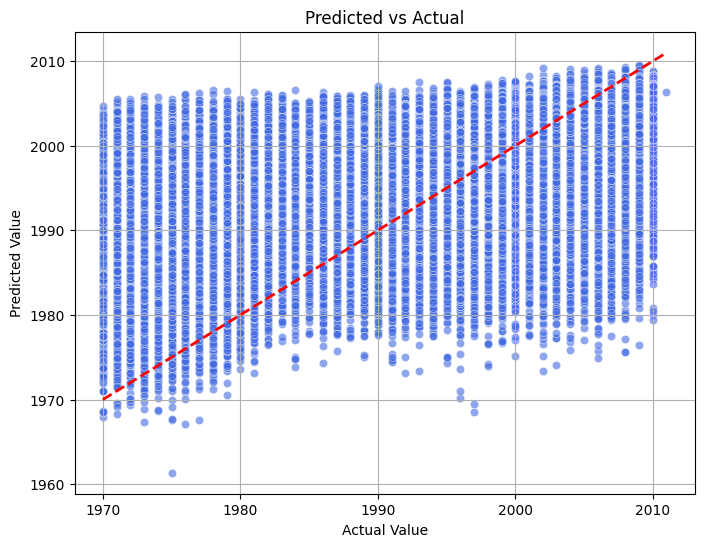

In [13]:

# === 12. Visualisasi Predicted vs Actual ===
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_all.flatten(), y=y_pred.flatten(), alpha=0.6, color='royalblue')
plt.plot([y_all.min(), y_all.max()], [y_all.min(), y_all.max()], 'r--', lw=2)
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('Predicted vs Actual')
plt.grid(True)
plt.show()

In [14]:
# === 14. Kesimpulan Pemilihan Metrik ===
best_metric = "R2 Score" if r2 > 0.8 else "RMSE"
print(f"\n👉 Berdasarkan hasil evaluasi, metrik terbaik untuk menilai performa model ini adalah: {best_metric}")


👉 Berdasarkan hasil evaluasi, metrik terbaik untuk menilai performa model ini adalah: RMSE


## **Data Tidak Memadai atau Tidak Relevan**

Data yang digunakan untuk pelatihan sangat mempengaruhi performa model. Jika data yang digunakan tidak representatif atau mengandung kesalahan, model akan kesulitan untuk menemukan pola yang relevan, yang dapat mengakibatkan hasil yang buruk.

### **Kualitas Data**
Data yang buruk atau mengandung banyak **noise** (gangguan) dapat sangat memengaruhi akurasi dan kemampuan model untuk belajar. Noise dalam data bisa berupa:
- Nilai yang hilang (missing values)
- Kesalahan pencatatan atau input data
- Data yang tidak relevan dengan masalah yang ingin diselesaikan
- Outlier (nilai ekstrem yang tidak mencerminkan pola yang ada)

Jika model dilatih dengan data yang tidak bersih, ia akan belajar dari informasi yang salah atau tidak relevan. Misalnya, jika terdapat banyak data yang hilang atau kesalahan dalam input data, model akan mempelajari hubungan yang tidak ada dalam dunia nyata, yang menyebabkan prediksi yang tidak akurat.

#### Solusi untuk Kualitas Data yang Buruk:
1. **Mengisi Nilai yang Hilang**: Salah satu cara untuk menangani data yang hilang adalah dengan menggantinya menggunakan teknik imputasi. Misalnya, menggunakan rata-rata atau median untuk menggantikan nilai yang hilang pada kolom numerik, atau menggunakan modus pada kolom kategorikal.
2. **Menghapus Outliers**: Outlier adalah nilai yang sangat berbeda dari sebagian besar data lainnya. Outlier bisa terjadi karena kesalahan pengukuran atau kondisi yang sangat jarang. Jika model dilatih dengan data yang mengandung outlier, ia bisa terdorong untuk memberi perhatian yang berlebihan pada data tersebut, yang berujung pada overfitting atau kesalahan prediksi.
3. **Normalisasi/Standarisasi Data**: Banyak model mesin pembelajaran (seperti model regresi atau algoritma berbasis gradient descent) bekerja lebih baik ketika data telah dinormalisasi atau distandarisasi. Hal ini memastikan bahwa semua fitur berada pada skala yang sama dan tidak ada fitur yang mendominasi karena memiliki rentang nilai yang lebih besar.

### **Jumlah Data yang Tidak Cukup**
Jumlah data yang tidak mencukupi juga menjadi faktor utama penyebab buruknya hasil model. Model yang terlalu sedikit data akan kesulitan dalam menemukan pola yang signifikan. Hal ini sangat umum terjadi pada masalah dengan data yang tidak seimbang atau data langka. Pada kasus ini, model tidak memiliki cukup contoh untuk menggeneralisasi pola yang ada dengan baik.

Jumlah data yang terbatas dapat menyebabkan dua masalah utama:
- **Underfitting**: Model mungkin tidak cukup belajar untuk menangkap pola yang ada dalam data.
- **Generalization Problem**: Model yang dilatih dengan sedikit data akan kesulitan dalam memprediksi data yang belum pernah dilihat sebelumnya (data uji).

#### Solusi untuk Jumlah Data yang Tidak Cukup:
1. **Mengumpulkan Lebih Banyak Data**: Solusi paling langsung untuk masalah ini adalah dengan mengumpulkan lebih banyak data. Ini bisa dilakukan dengan meningkatkan proses pengumpulan data atau menggali data tambahan dari sumber yang relevan.
2. **Data Augmentation**: Jika mengumpulkan data lebih banyak sulit, teknik seperti data augmentation bisa digunakan untuk memperbesar dataset yang ada. Teknik ini sangat umum digunakan dalam bidang visi komputer, di mana gambar bisa diputar, dipotong, atau diubah untuk menghasilkan variasi baru dari data yang sudah ada. Di bidang teks, augmentasi dapat dilakukan dengan teknik seperti parafrase atau penerjemahan.
3. **Synthetic Data**: Dalam beberapa kasus, terutama pada masalah yang sangat terbatas datanya, bisa dipertimbangkan untuk menghasilkan data sintetis menggunakan teknik seperti simulasi komputer atau model generatif (misalnya, Generative Adversarial Networks atau GANs). Data sintetis ini bisa membantu model belajar lebih baik meskipun data asli terbatas.

### Kesimpulan
Data yang berkualitas tinggi dan cukup banyak adalah fondasi penting bagi model pembelajaran mesin yang efektif. Tanpa data yang baik, model akan kesulitan untuk memberikan hasil yang memuaskan. Melalui teknik preprocessing yang baik dan pengumpulan data yang cukup, kita dapat meningkatkan kemampuan model untuk mempelajari pola yang relevan dan memberikan prediksi yang lebih akurat.
